In [1]:
import os
os.chdir('../')
from python_code import gibbs_sampler as gs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.style as style
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
from itertools import combinations
import pymc3 as pm

In [2]:
df = pd.read_csv('../data/mathtest.csv')
df.columns = ['group', 'values']

In [3]:
gibbs = gs.GibbsSampler(df, n_iter=5000, burn=100)

In [4]:
gibbs.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1027.46it/s]


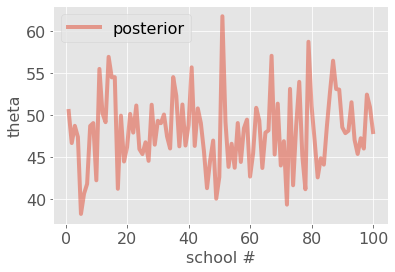

In [5]:
group = df.groupby('group')
plt.plot(np.unique(df['group']),gibbs.traces['theta'].mean(axis=0),alpha=.5, label='posterior')
plt.legend()
plt.xlabel('school #', fontsize=16)
plt.ylabel('theta', fontsize=16);

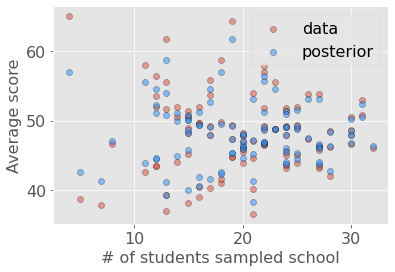

In [6]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='data');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

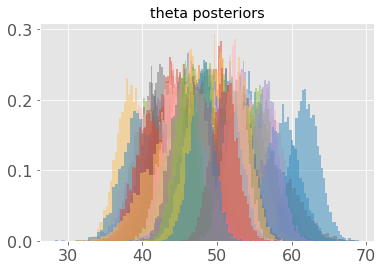

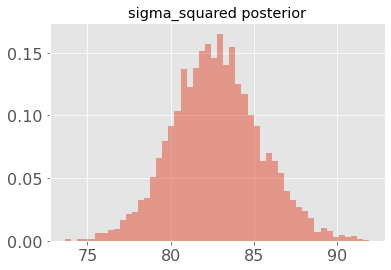

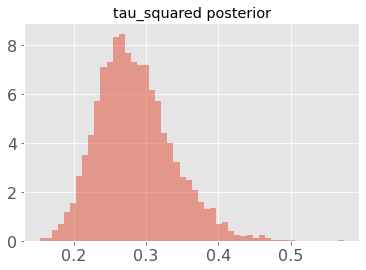

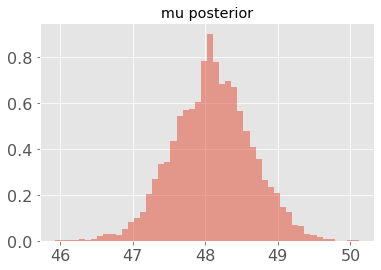

<Figure size 432x288 with 0 Axes>

In [7]:
gibbs.plot_all_posteriors();

In [34]:
post_mean = gibbs.traces['mu'][:, None]
y_i_mean = group.mean().to_numpy().flatten()
ki = (1/gibbs.n_i)/(gibbs.traces['tau_squared'][:, None]*np.ones(gibbs.P) + 1/gibbs.n_i).mean(axis=0)

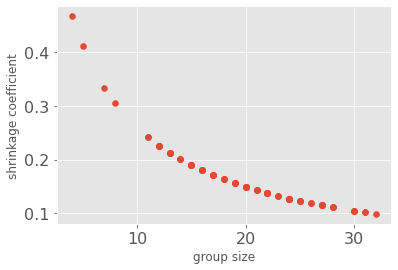

In [35]:
plt.scatter(group.size(), ki)
plt.xlabel('group size')
plt.ylabel('shrinkage coefficient');

In [36]:
mu = gibbs.traces['mu'].mean()
cov_schools = np.zeros(gibbs.P)
for school in range(gibbs.P):
    all_idx = list(range(gibbs.n_i[school]))
    combs = list(combinations(all_idx, 2))
    combs_not_identical = [comb for comb in combs if combs[0] != combs[1]]
    rows = df[df['group'] == school + 1].reset_index()['values']
    terms = []
    for comb in combs_not_identical:
        terms.append((rows.iloc[comb[0]]-mu) * (rows.iloc[comb[1]]-mu))
    cov_schools[school] = np.mean(terms)

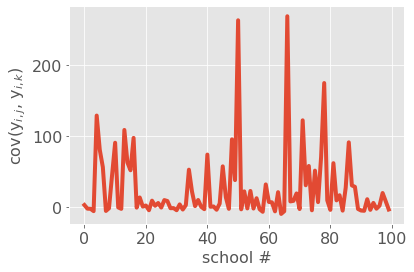

In [37]:
plt.plot(cov_schools)
plt.xlabel('school #', fontsize=16)
plt.ylabel('cov(y$_{i,j}$, y$_{i,k}$)', fontsize=16);

In [38]:
all_idx = list(range(gibbs.P))
combs = list(combinations(all_idx, 2))
combs_not_identical = [comb for comb in combs if combs[0] != combs[1]]
terms = []
for comb in combs_not_identical:
    terms.append((cov_schools[comb[0]] - mu)*(cov_schools[comb[0]] - mu))
cov = np.mean(terms)

In [39]:
cov

2736.1102097920693

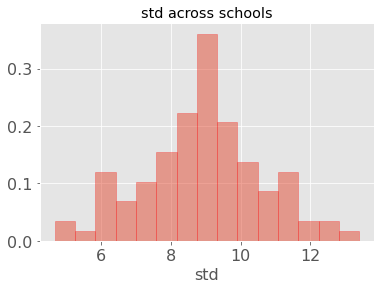

In [40]:
plt.hist(group.std(), alpha=0.5, edgecolor='red', bins=15, density=True);
plt.title('std across schools');
plt.xlabel('std', fontsize=16);

### try with pymc

In [15]:
theta_means = []
from tqdm import tqdm
for school in tqdm(range(gibbs.P)):
    data = df[df['group'] == school+1]
    traces = {'sigma': np.zeros(2000),
                       'tau': np.zeros(2000),
                       'mu': np.zeros(2000),
                       'theta': np.zeros(2000)}
    
    with pm.Model() as model:
        sigma = pm.Normal('sigma',mu=1e-6, sigma=1e3)
        mu = pm.Normal('mu',mu=1e-6, sigma=1e3)
        tau = pm.InverseGamma('tau',0.5,0.5)
        theta = pm.Normal('theta', mu=mu, sd = tau*sigma)
        y = pm.Normal('y', mu=theta, sd=sigma, observed=data['values'])
        try:
            trace = pm.sample(2000, tune = 1000, chains=2,cores=1, return_inferencedata=False)
            theta_means.append(trace.get_values('theta').mean())
        except:
             theta_means.append(None)
             


  0%|                                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 661 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5471764814525072, but should be close to 0.8. Try to increase the number of tuning steps.
There were 995 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7207419692014825, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  1%|█▊                                                                                                                                                                                         | 1/100 [00:10<17:56, 10.87s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 193 divergences after tuning. Increase `target_accept` or reparameterize.
There were 439 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
  2%|███▋                                                                                                                                                                                       | 2/100 [00:16<13:01,  7.97s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 482 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6321772576187465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1254 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4751946123160392, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  3%|█████▌                                                                                                                                                                                     | 3/100 [00:22<11:24,  7.05s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6191658070870797, but should be close to 0.8. Try to increase the number of tuning steps.
There were 704 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  4%|███████▍                                                                                                                                                                                   | 4/100 [00:28<10:23,  6.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 545 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.569656176810276, but should be close to 0.8. Try to increase the number of tuning steps.
There were 716 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
  5%|█████████▎                                                                                                                                                                                 | 5/100 [00:34<09:49,  6.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 454 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6719197131903073, but should be close to 0.8. Try to increase the number of tuning steps.
There were 791 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.703733643065842, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  6%|███████████▏                                                                                                                                                                               | 6/100 [00:40<09:37,  6.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
N

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 603 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.579328972953056, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1270 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4917453868996674, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
  7%|█████████████                                                                                                                                                                              | 7/100 [00:46<09:45,  6.29s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 761 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4613603735816333, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1015 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  8%|██████████████▉                                                                                                                                                                            | 8/100 [00:52<09:35,  6.25s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.28172716469788384, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1960 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5372130759335775, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
  9%|████████████████▊                                                                                                                                                                          | 9/100 [00:58<09:06,  6.00s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 451 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6460526928243289, but should be close to 0.8. Try to increase the number of tuning steps.
There were 809 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7174127844758525, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 10%|██████████████████▌                                                                                                                                                                       | 10/100 [01:04<09:01,  6.01s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 460 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6481300434531287, but should be close to 0.8. Try to increase the number of tuning steps.
There were 760 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7210202848862113, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 11%|████████████████████▍                                                                                                                                                                     | 11/100 [01:10<08:50,  5.96s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1012 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37673044612895945, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1697 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.499492866869744, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 12%|██████████████████████▎                                                                                                                                                                   | 12/100 [01:15<08:15,  5.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 13%|████████████████████████▏                                                                                                                                                                 | 13/100 [01:18<07:22,  5.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 757 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47750419591339216, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1873 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3068229008518979, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 14%|██████████████████████████                                                                                                                                                                | 14/100 [01:24<07:20,  5.12s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 461 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6204452844124408, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1360 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2994774734600563, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 15%|███████████████████████████▉                                                                                                                                                              | 15/100 [01:30<07:44,  5.46s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33690548108991486, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1659 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5993462267127673, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 16%|█████████████████████████████▊                                                                                                                                                            | 16/100 [01:35<07:38,  5.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 688 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47978591829543743, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1845 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.31799820484090663, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 17%|███████████████████████████████▌                                                                                                                                                          | 17/100 [01:41<07:28,  5.40s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1703 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.10451775426233864, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2264 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5864046387044185, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 18%|█████████████████████████████████▍                                                                                                                                                        | 18/100 [01:46<07:19,  5.36s/it]Auto-assigning NUTS samp

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 911 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37304695552535894, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1213 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 19%|███████████████████████████████████▎                                                                                                                                                      | 19/100 [01:52<07:30,  5.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3211368446031454, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1784 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42833508459789077, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 20%|█████████████████████████████████████▏                                                                                                                                                    | 20/100 [01:57<07:06,  5.33s/it]Auto-assigning NUTS sampl

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 272 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1342 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3610697091367422, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 21%|███████████████████████████████████████                                                                                                                                                   | 21/100 [02:02<07:11,  5.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6653079925635238, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1319 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44002561657074535, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 22%|████████████████████████████████████████▉                                                                                                                                                 | 22/100 [02:08<07:04,  5.45s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 428 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6751942837054505, but should be close to 0.8. Try to increase the number of tuning steps.
There were 954 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6030832029142773, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 23%|██████████████████████████████████████████▊                                                                                                                                               | 23/100 [02:13<07:03,  5.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1230 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22116931779879034, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2063 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4714038644521841, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 24%|████████████████████████████████████████████▋                                                                                                                                             | 24/100 [02:18<06:45,  5.34s/it]Auto-assigning NUTS samp

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 467 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6476975955499357, but should be close to 0.8. Try to increase the number of tuning steps.
There were 997 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5762109639869045, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 25%|██████████████████████████████████████████████▌                                                                                                                                           | 25/100 [02:24<06:46,  5.41s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1151 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2704230782029963, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1537 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.699686427020931, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 26%|████████████████████████████████████████████████▎                                                                                                                                         | 26/100 [02:29<06:37,  5.37s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 906 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4168878633460157, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1479 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5440903856493945, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 27%|██████████████████████████████████████████████████▏                                                                                                                                       | 27/100 [02:34<06:19,  5.20s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 361 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6692564735301939, but should be close to 0.8. Try to increase the number of tuning steps.
There were 821 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6084164064450497, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 28%|████████████████████████████████████████████████████                                                                                                                                      | 28/100 [02:40<06:32,  5.45s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 766 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47189980008151156, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1619 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45322558085729636, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 29%|█████████████████████████████████████████████████████▉                                                                                                                                    | 29/100 [02:46<06:25,  5.43s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 324 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7134570041073055, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1426 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33291087095910793, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 30%|███████████████████████████████████████████████████████▊                                                                                                                                  | 30/100 [02:51<06:29,  5.56s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 505 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.642674511899705, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1041 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.506101394648039, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 31%|█████████████████████████████████████████████████████████▋                                                                                                                                | 31/100 [02:57<06:32,  5.69s/it]Auto-assi

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 32%|███████████████████████████████████████████████████████████▌                                                                                                                              | 32/100 [03:01<05:42,  5.04s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 623 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.544786829644164, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1004 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.691806382132596, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 33%|█████████████████████████████████████████████████████████████▍                                                                                                                            | 33/100 [03:06<05:46,  5.17s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
N

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 543 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5962109877457933, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5289138723884733, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 34%|███████████████████████████████████████████████████████████████▏                                                                                                                          | 34/100 [03:12<05:45,  5.24s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 443 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6418825094341899, but should be close to 0.8. Try to increase the number of tuning steps.
There were 807 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6836924869373616, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 35%|█████████████████████████████████████████████████████████████████                                                                                                                         | 35/100 [03:17<05:48,  5.36s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 6 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8861122227555588, but should be close to 0.8. Try to increase the number of tuning steps.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 36%|██████████████████████████████████████████████████████████████████▉                                                                                                                       | 36/100 [03:25<06:29,  6.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 37%|████████████████████████████████████████████████████████████████████▊                                                                                                                     | 37/100 [03:28<05:23,  5.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 504 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5900448898185378, but should be close to 0.8. Try to increase the number of tuning steps.
There were 891 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7077596241159801, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 38%|██████████████████████████████████████████████████████████████████████▋                                                                                                                   | 38/100 [03:34<05:32,  5.36s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 594 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5703107068658351, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6041579686946583, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 39%|████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 39/100 [03:40<05:33,  5.46s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1226 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2108359803333444, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1771 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5637977055001911, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 40%|██████████████████████████████████████████████████████████████████████████▍                                                                                                               | 40/100 [03:45<05:25,  5.43s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6413230833381013, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1029 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5553083412725989, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 41%|████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 41/100 [03:50<05:18,  5.41s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 637 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5327543927172432, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1386 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5062046959837627, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 42%|██████████████████████████████████████████████████████████████████████████████                                                                                                            | 42/100 [03:56<05:22,  5.56s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 521 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5820082769558849, but should be close to 0.8. Try to increase the number of tuning steps.
There were 935 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6410273919701808, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 43%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 43/100 [04:02<05:13,  5.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1097 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.37556218141422015, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1517 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5956513600209035, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 44%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 44/100 [04:07<05:06,  5.47s/it]Auto-

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 700 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5469761636068543, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5784891387529992, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 45%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 45/100 [04:12<04:57,  5.41s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 745 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4275464275249018, but should be close to 0.8. Try to increase the number of tuning steps.
There were 979 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 46%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 46/100 [04:19<05:05,  5.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 613 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5499108078951239, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1077 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6272912518990711, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 47%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 47/100 [04:25<05:17,  6.00s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.702860313374032, but should be close to 0.8. Try to increase the number of tuning steps.
There were 855 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6135420064453398, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 48%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 48/100 [04:32<05:18,  6.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
N

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1278 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2867416198975765, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5487111190300116, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 49%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 49/100 [04:37<04:59,  5.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 558 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.604249291228383, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1017 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.645782114805583, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 50%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 50/100 [04:43<04:53,  5.86s/it]Auto-assi

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 618 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5416129552540706, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1481 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.425044761743114, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 51%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 51/100 [04:49<04:48,  5.89s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 748 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5098543407610949, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1407 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5109071235715678, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 52%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 52/100 [04:55<04:39,  5.83s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 835 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4915326970154788, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1659 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.426397076317487, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 53%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 53/100 [05:00<04:30,  5.76s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 348 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6778826310279783, but should be close to 0.8. Try to increase the number of tuning steps.
There were 970 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5709360883510571, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 54%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 54/100 [05:06<04:19,  5.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 476 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6426975637177079, but should be close to 0.8. Try to increase the number of tuning steps.
There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6437225251024505, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 55/100 [05:13<04:34,  6.09s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 665 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5148768409441423, but should be close to 0.8. Try to increase the number of tuning steps.
There were 800 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 56/100 [05:19<04:29,  6.12s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 57/100 [05:22<03:49,  5.33s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 783 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42081876900704895, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1402 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45139656404384026, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 58/100 [05:28<03:42,  5.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 646 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.535289278565681, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1467 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4540010927485151, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 59/100 [05:33<03:38,  5.33s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 314 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7143184971733882, but should be close to 0.8. Try to increase the number of tuning steps.
There were 738 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6084939506536278, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 60/100 [05:38<03:31,  5.30s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.705487091100816, but should be close to 0.8. Try to increase the number of tuning steps.
There were 912 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5588165684703562, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 61/100 [05:44<03:30,  5.40s/it]Auto-assi

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 559 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5569874509117747, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1581 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3648898352486497, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 62/100 [05:49<03:23,  5.35s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 609 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.525042015913079, but should be close to 0.8. Try to increase the number of tuning steps.
There were 931 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6877959796491925, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 63/100 [05:54<03:16,  5.31s/it]Auto-assi

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 367 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7041940263411492, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1676 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19607847019308042, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 64/100 [06:00<03:10,  5.31s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 402 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6209046870142726, but should be close to 0.8. Try to increase the number of tuning steps.
There were 780 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6630123663988923, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 65/100 [06:05<03:10,  5.45s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 896 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.45631368498849156, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1191 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 66/100 [06:11<03:02,  5.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 5 seconds.
There were 652 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5477066815278693, but should be close to 0.8. Try to increase the number of tuning steps.
There were 857 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 67/100 [06:17<03:06,  5.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 544 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5709061515457396, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1094 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5952513268815337, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 68/100 [06:22<03:00,  5.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 658 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4553999216343171, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1580 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4301999310047746, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 69/100 [06:28<02:54,  5.64s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1674 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11814077933084306, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2416 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42668024941033095, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 70/100 [06:33<02:41,  5.38s/it]Auto-assigning NUTS sam

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1369 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25955062994672945, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3320 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.017375417493548234, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 71/100 [06:38<02:35,  5.35s/it]Auto-assigning NUTS sa

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 626 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5542852480670712, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1070 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6023631154176592, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 72/100 [06:44<02:34,  5.52s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 445 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6052590010913316, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1052 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5227321680579285, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 73/100 [06:50<02:31,  5.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1170 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19951222275001482, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1665 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.664975727539206, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 74/100 [06:56<02:27,  5.69s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 601 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5151738537380536, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1078 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6310052334846168, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 75/100 [07:02<02:25,  5.81s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 509 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6000842041370363, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1046 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5867841077399553, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 76/100 [07:08<02:22,  5.94s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 763 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4167328003714912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1875 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30203728523140744, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 77/100 [07:13<02:11,  5.72s/it]Auto-assigning NUTS sampler...
Initializing NUTS using 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 763 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4449299177508371, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1162 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6572263091312279, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 78/100 [07:19<02:04,  5.64s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 970 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4083261563646984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1774 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46891288851020146, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 79/100 [07:24<01:55,  5.51s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 612 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6196159223621581, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.535779444646425, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 80/100 [07:30<01:50,  5.53s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 950 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42365572654017997, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1489 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6119422777393578, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 81/100 [07:35<01:46,  5.61s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 791 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4289554443835726, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1198 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6932187943074346, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 82/100 [07:41<01:40,  5.56s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 507 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6226002556530007, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5513253051368886, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 83/100 [07:46<01:32,  5.42s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 226 divergences after tuning. Increase `target_accept` or reparameterize.
There were 916 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47758090816307674, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 84/100 [07:52<01:29,  5.59s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 758 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4814818929148228, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1673 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39482354416745935, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 85/100 [07:57<01:22,  5.52s/it]Auto-assigning NUTS sampl

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 713 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5226302274051179, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1079 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6692451316502445, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 86/100 [08:03<01:16,  5.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 414 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6633064690327698, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1725 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2120853589167069, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 87/100 [08:08<01:11,  5.48s/it]Auto-assigning NUTS sampler...
Initializing NUTS using j

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 480 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6139518235430224, but should be close to 0.8. Try to increase the number of tuning steps.
There were 977 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.574772688139977, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 88/100 [08:14<01:06,  5.52s/it]Auto-assi

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 339 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6935022183869332, but should be close to 0.8. Try to increase the number of tuning steps.
There were 982 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5658181463905695, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 89/100 [08:19<01:01,  5.55s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 818 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46326214182412584, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1312 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5839979354149195, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/100 [08:25<00:55,  5.60s/it]Auto-a

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6256832817924497, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1360 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.33113722029430204, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 91/100 [08:30<00:48,  5.43s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 1343 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23960792836682554, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1943 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5709346919882501, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 92/100 [08:36<00:44,  5.61s/it]Auto-assigning NUTS sampler...
Initializing NUTS using

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 574 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5090590120439925, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1567 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3848349269120602, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 93/100 [08:41<00:38,  5.45s/it]Auto-as

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 878 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43663268772484515, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2329 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18671862032711709, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 94/100 [08:46<00:30,  5.13s/it]Auto-assigning NUTS samp

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6841946080886311, but should be close to 0.8. Try to increase the number of tuning steps.
There were 849 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5523707425051004, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 95/100 [08:52<00:27,  5.42s/it]Auto-ass

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 470 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.59179272130284, but should be close to 0.8. Try to increase the number of tuning steps.
There were 994 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5156367434725687, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 96/100 [08:58<00:22,  5.54s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NU

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1983 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0896735934760119, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 97/100 [09:03<00:16,  5.50s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6955348115796922, but should be close to 0.8. Try to increase the number of tuning steps.
There were 879 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6203209967720686, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 98/100 [09:10<00:11,  5.87s/it]Auto-assigning NUTS sampler...
Initializing NUTS using ji

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:224: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(1, self._stds, out=self._inv_stds)
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:203: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(self._var, x, out=out)
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 99/100 [09:13<00:05,  5.13s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
There were 1299 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.25537399061515803, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2377 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3484400530343277, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:18<00:00,  5.58s/it]


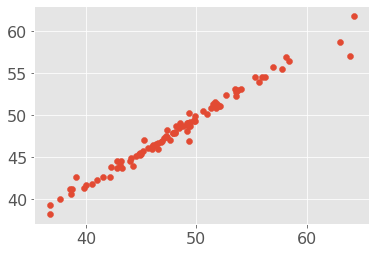

In [16]:
gibbs_means = gibbs.traces['theta'].mean(axis=0)
plt.scatter(theta_means, gibbs_means)

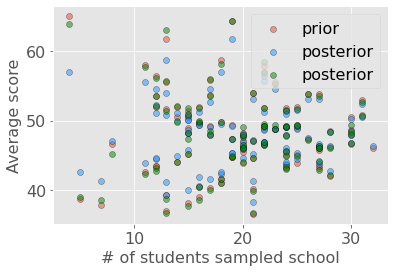

In [17]:
plt.scatter(group.size(), group.mean(), alpha=.5, edgecolor='black', label='prior');
plt.scatter(group.size(), gibbs.traces['theta'].mean(axis=0), color='dodgerblue', alpha=.5, edgecolor='black', label='posterior');
plt.scatter(group.size(), theta_means, color='green', alpha=.5, edgecolor='black', label='posterior');

plt.xlabel('# of students sampled school', fontsize=16)
plt.legend()
plt.ylabel('Average score', fontsize=16);

In [18]:
df.groupby('group').size()

group
1      31
2      22
3      23
4      19
5      21
       ..
96     21
97     27
98     31
99     24
100    30
Length: 100, dtype: int64

In [19]:
df

,group,values
0,1,52.11
1,1,57.65
2,1,66.44
3,1,44.68
4,1,40.57
...,...,...
1988,100,54.95
1989,100,30.29
1990,100,47.66
1991,100,55.43
